In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)

# 历史天气部分

## 将经纬度找到指定的county

In [2]:
historical_weather = pd.read_csv("../data/historical_weather.csv",parse_dates=['datetime'])
# 将时间往后推移37个小时，与train的datetime同步
historical_weather['datetime'] = historical_weather['datetime'].apply(lambda x: x+pd.Timedelta(37, 'H'))

In [3]:
"""
historical_weather['year'] = historical_weather['datetime'].apply(lambda x: x.year)
historical_weather['month'] = historical_weather['datetime'].apply(lambda x: x.month)
historical_weather['day'] = historical_weather['datetime'].apply(lambda x: x.day)
historical_weather['hour'] = historical_weather['datetime'].apply(lambda x: x.hour)
historical_weather.head()
"""

"\nhistorical_weather['year'] = historical_weather['datetime'].apply(lambda x: x.year)\nhistorical_weather['month'] = historical_weather['datetime'].apply(lambda x: x.month)\nhistorical_weather['day'] = historical_weather['datetime'].apply(lambda x: x.day)\nhistorical_weather['hour'] = historical_weather['datetime'].apply(lambda x: x.hour)\nhistorical_weather.head()\n"

In [4]:
# 将经纬度取一位小数
historical_weather['latitude'] = historical_weather['latitude'].astype(float).round(1)
historical_weather['longitude'] = historical_weather['longitude'].astype(float).round(1)

In [5]:
weather_to_county = pd.read_csv("../data/weather_station_to_county_mapping.csv")
weather_to_county

,county_name,longitude,latitude,county
0,NaN,21.7,57.6,NaN
1,NaN,21.7,57.9,NaN
2,NaN,21.7,58.2,NaN
3,NaN,21.7,58.5,NaN
4,NaN,21.7,58.8,NaN
...,...,...,...,...
107,NaN,28.2,58.5,NaN
108,NaN,28.2,58.8,NaN
109,NaN,28.2,59.1,NaN
110,NaN,28.2,59.4,NaN


In [6]:
weather_to_county.groupby(by=["longitude","latitude"])["county"].describe().unstack().count()

       latitude
count  57.6        14
       57.9        14
       58.2        14
       58.5        14
       58.8        14
                   ..
max    58.5        11
       58.8         8
       59.1         9
       59.4         8
       59.7         0
Length: 64, dtype: int64

In [7]:
location = pd.read_csv("../data/county_lon_lats.csv").drop(columns = ["Unnamed: 0"])

# Convert to int to avoid float imprecision
for k in ['latitude', 'longitude'] :
    location[k] = (10*location[k]).astype(int)

location

,county,longitude,latitude
0,0,242,591
1,0,252,591
2,0,237,594
3,0,242,594
4,0,247,594
...,...,...,...
70,15,267,576
71,15,272,576
72,15,267,579
73,15,272,579


In [8]:
def process_weather_info(h, location=location) :

    # Drop duplicates
    h = h.drop_duplicates().reset_index(drop=True)

    # Convert to int to avoid float imprecision
    for k in ['latitude', 'longitude'] :
        h[k] = (10*h[k]).astype(int)

    # Add location
    h = pd.merge(h, location, how='left', on=['latitude', 'longitude'])

    # drop na
    h.dropna(subset=['county'], inplace=True)

    # Return
    return h

In [9]:
# 拼接经纬度
historical_weather = process_weather_info(historical_weather)
# 由于一个county同一时刻对应多个站点，将他们平均
historical_weather = historical_weather.groupby(by=['datetime', 'county']).mean()
historical_weather.drop(columns=['data_block_id'], inplace=True)
historical_weather

temperature   dewpoint      rain  snowfall  \
datetime            county                                               
2021-09-02 13:00:00 0.0       13.520000  11.110000  0.000000       0.0   
                    1.0       13.966667  11.050000  0.000000       0.0   
                    2.0       12.375000  11.075000  0.000000       0.0   
                    3.0       11.100000   9.633333  0.000000       0.0   
                    4.0       12.475000  10.600000  0.000000       0.0   
...                                 ...        ...       ...       ...   
2023-05-31 23:00:00 10.0      12.600000   6.133333  0.016667       0.0   
                    11.0      12.525000   3.125000  0.000000       0.0   
                    13.0      13.300000   4.300000  0.000000       0.0   
                    14.0      13.100000   4.400000  0.000000       0.0   
                    15.0      12.980000   3.580000  0.000000       0.0   

                            surface_pressure  cloudcover_total  \
datetime            county                                       
2021-09-02 13:00:00 0.0          1010.260000         52.400000   
                    1.0          1015.183333          4.500000   
                    2.0          1006.175000         34.250000   
                    3.0          1004.166667         75.666667   
                    4.0          1005.200000         34.250000   
...                                      ...               ...   
2023-05-31 23:00:00 10.0         1019.358333         11.666667   
                    11.0         1010.350000         58.750000   
                    13.0         1012.400000         62.000000   
                    14.0         1011.333333         29.666667   
                    15.0         1005.080000         40.400000   

                            cloudcover_low  cloudcover_mid  cloudcover_high  \
datetime            county                                                    
2021-09-02 13:00:00 0.0          53.600000        7.300000         0.000000   
                    1.0           3.500000        0.000000         4.333333   
                    2.0          31.000000        1.000000        18.750000   
                    3.0          80.333333        6.000000         0.333333   
                    4.0          26.500000        0.000000        34.500000   
...                                    ...             ...              ...   
2023-05-31 23:00:00 10.0          2.416667       15.583333         0.000000   
                    11.0         12.000000       80.000000         0.000000   
                    13.0         16.000000       79.000000         0.000000   
                    14.0          6.666667       40.000000         0.000000   
                    15.0          7.000000       57.000000         0.000000   

                            windspeed_10m  winddirection_10m  \
datetime            county                                     
2021-09-02 13:00:00 0.0          4.080556         323.700000   
                    1.0          6.976852         350.666667   
                    2.0          2.611111         325.250000   
                    3.0          2.027778         313.666667   
                    4.0          3.277778         340.250000   
...                                   ...                ...   
2023-05-31 23:00:00 10.0         5.791667         325.250000   
                    11.0         1.993056         291.500000   
                    13.0         2.027778         290.000000   
                    14.0         2.305556         267.666667   
                    15.0         1.938889         327.200000   

                            shortwave_radiation  direct_solar_radiation  \
datetime            county                                                
2021-09-02 13:00:00 0.0                0.000000                     0.0   
                    1.0                0.000000                     0.0   
                    2.0                0.0000

保存成新的csv，成功后就不运行了

In [10]:
# historical_weather.to_csv('../data/historical_weather_New.csv')

In [11]:
# historical_weather = historical_weather.drop_duplicates(['datetime','county'])

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
train = pd.read_csv("../data/train.csv",parse_dates=['datetime'])
train['county'] = train['county'].astype(int)
train.drop_duplicates(inplace=True)

In [14]:
train['year'] = train['datetime'].apply(lambda x: x.year)
train['month'] = train['datetime'].apply(lambda x: x.month)
train['day'] = train['datetime'].apply(lambda x: x.day)
train['hour'] = train['datetime'].apply(lambda x: x.hour)
train.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,year,month,day,hour
0,0,0,1,0.713,0,2021-09-01,0,0,0,2021,9,1,0
1,0,0,1,96.590,1,2021-09-01,0,1,0,2021,9,1,0
2,0,0,2,0.000,0,2021-09-01,0,2,1,2021,9,1,0
3,0,0,2,17.314,1,2021-09-01,0,3,1,2021,9,1,0
4,0,0,3,2.904,0,2021-09-01,0,4,2,2021,9,1,0


In [15]:
train_new= train[['county', 'data_block_id', 'target','is_consumption','is_business','product_type','hour', 'datetime']]
train_new_is_consumption = train_new[train_new['is_consumption']==1]
train_new_is_consumption

,county,data_block_id,target,is_consumption,is_business,product_type,hour,datetime
1,0,0,96.590,1,0,1,0,2021-09-01 00:00:00
3,0,0,17.314,1,0,2,0,2021-09-01 00:00:00
5,0,0,656.859,1,0,3,0,2021-09-01 00:00:00
7,0,0,59.000,1,1,0,0,2021-09-01 00:00:00
9,0,0,501.760,1,1,1,0,2021-09-01 00:00:00
...,...,...,...,...,...,...,...,...
2018343,15,637,42.401,1,0,1,23,2023-05-31 23:00:00
2018345,15,637,117.332,1,0,3,23,2023-05-31 23:00:00
2018347,15,637,197.233,1,1,0,23,2023-05-31 23:00:00
2018349,15,637,28.404,1,1,1,23,2023-05-31 23:00:00


In [16]:
train_group_by = train.groupby('county')['target'].describe()
train_group_by

,count,mean,std,min,25%,50%,75%,max
county,,,,,,,,
0,212872.0,941.325522,2212.134626,0.0,0.73200,52.0210,685.05800,15480.274
1,91848.0,38.133914,56.566706,0.0,0.34400,13.6690,59.01725,436.720
2,115170.0,129.888047,343.995260,0.0,0.13500,20.5190,75.18400,3036.604
3,122464.0,162.450176,315.471636,0.0,0.32175,30.5930,108.20225,1866.010
4,147226.0,147.658768,250.709334,0.0,0.02525,22.4740,159.04475,1512.696
5,151592.0,231.044165,399.949721,0.0,0.65800,57.8050,217.46700,2489.182
6,30616.0,92.219639,117.457851,0.0,0.00400,48.3420,147.21550,983.878
7,173042.0,205.114767,315.637695,0.0,0.34600,48.1795,286.48875,3938.318
8,91848.0,88.359405,156.282531,0.0,0.05500,20.1920,107.16775,2247.461


In [17]:
merged_is_consumption = pd.merge(train_new_is_consumption, historical_weather, how='left', on=['datetime', 'county'])
merged_is_consumption

,county,data_block_id,target,is_consumption,is_business,product_type,hour,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude
0,0,0,96.590,1,0,1,0,2021-09-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,17.314,1,0,2,0,2021-09-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,656.859,1,0,3,0,2021-09-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,59.000,1,1,0,0,2021-09-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,501.760,1,1,1,0,2021-09-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009171,15,637,42.401,1,0,1,23,2023-05-31 23:00:00,12.98,3.58,0.0,0.0,1005.08,40.4,7.0,57.0,0.0,1.938889,327.2,394.6,231.8,162.8,577.8,271.0
1009172,15,637,117.332,1,0,3,23,2023-05-31 23:00:00,12.98,3.58,0.0,0.0,1005.08,40.4,7.0,57.0,0.0,1.938889,327.2,394.6,231.8,162.8,577.8,271.0
1009173,15,637,197.233,1,1,0,23,2023-05-31 23:00:00,12.98,3.58,0.0,0.0,1005.08,40.4,7.0,57.0,0.0,1.938889,327.2,394.6,231.8,162.8,577.8,271.0
1009174,15,637,28.404,1,1,1,23,2023-05-31 23:00:00,12.98,3.58,0.0,0.0,1005.08,40.4,7.0,57.0,0.0,1.938889,327.2,394.6,231.8,162.8,577.8,271.0


In [18]:
train_new_no_consumption = train_new[train_new['is_consumption']==0]
merged_no_consumption  = pd.merge(train_new_no_consumption, historical_weather,how='left', on=['datetime', 'county'])

In [19]:
merged_no_consumption['hour'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23], dtype=int64)

In [20]:
merged_is_consumption = merged_is_consumption .dropna()
merged_no_consumption = merged_no_consumption .dropna()
merged_no_consumption
merged_is_consumption

,county,data_block_id,target,is_consumption,is_business,product_type,hour,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude
2257,0,1,28.354,1,0,1,13,2021-09-02 13:00:00,13.52,11.11,0.0,0.0,1010.26,52.4,53.6,7.3,0.0,4.080556,323.7,0.0,0.0,0.0,594.3,248.5
2258,0,1,6.505,1,0,2,13,2021-09-02 13:00:00,13.52,11.11,0.0,0.0,1010.26,52.4,53.6,7.3,0.0,4.080556,323.7,0.0,0.0,0.0,594.3,248.5
2259,0,1,155.423,1,0,3,13,2021-09-02 13:00:00,13.52,11.11,0.0,0.0,1010.26,52.4,53.6,7.3,0.0,4.080556,323.7,0.0,0.0,0.0,594.3,248.5
2260,0,1,62.700,1,1,0,13,2021-09-02 13:00:00,13.52,11.11,0.0,0.0,1010.26,52.4,53.6,7.3,0.0,4.080556,323.7,0.0,0.0,0.0,594.3,248.5
2261,0,1,576.216,1,1,1,13,2021-09-02 13:00:00,13.52,11.11,0.0,0.0,1010.26,52.4,53.6,7.3,0.0,4.080556,323.7,0.0,0.0,0.0,594.3,248.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009171,15,637,42.401,1,0,1,23,2023-05-31 23:00:00,12.98,3.58,0.0,0.0,1005.08,40.4,7.0,57.0,0.0,1.938889,327.2,394.6,231.8,162.8,577.8,271.0
1009172,15,637,117.332,1,0,3,23,2023-05-31 23:00:00,12.98,3.58,0.0,0.0,1005.08,40.4,7.0,57.0,0.0,1.938889,327.2,394.6,231.8,162.8,577.8,271.0
1009173,15,637,197.233,1,1,0,23,2023-05-31 23:00:00,12.98,3.58,0.0,0.0,1005.08,40.4,7.0,57.0,0.0,1.938889,327.2,394.6,231.8,162.8,577.8,271.0
1009174,15,637,28.404,1,1,1,23,2023-05-31 23:00:00,12.98,3.58,0.0,0.0,1005.08,40.4,7.0,57.0,0.0,1.938889,327.2,394.6,231.8,162.8,577.8,271.0


# 开始计算相关性（以county=0，product_type=1为例子）
## 消费target的相关性
### 消费且商用和target的相关性

In [21]:
merged_is_consumption_is_business = merged_is_consumption[(merged_is_consumption['county']==0)&(merged_is_consumption['product_type']==1)&(merged_is_consumption['is_business']==1)]
merged_is_consumption_is_business.corr().loc['target']

county                         NaN
data_block_id             0.194237
target                    1.000000
is_consumption                 NaN
is_business                    NaN
product_type                   NaN
hour                      0.074825
datetime                  0.194355
temperature              -0.602417
dewpoint                 -0.534386
rain                     -0.065237
snowfall                  0.202055
surface_pressure         -0.119889
cloudcover_total          0.364355
cloudcover_low            0.416877
cloudcover_mid            0.181945
cloudcover_high           0.080189
windspeed_10m             0.142442
winddirection_10m         0.058842
shortwave_radiation      -0.292151
direct_solar_radiation   -0.257286
diffuse_radiation        -0.303188
latitude                       NaN
longitude                      NaN
Name: target, dtype: float64

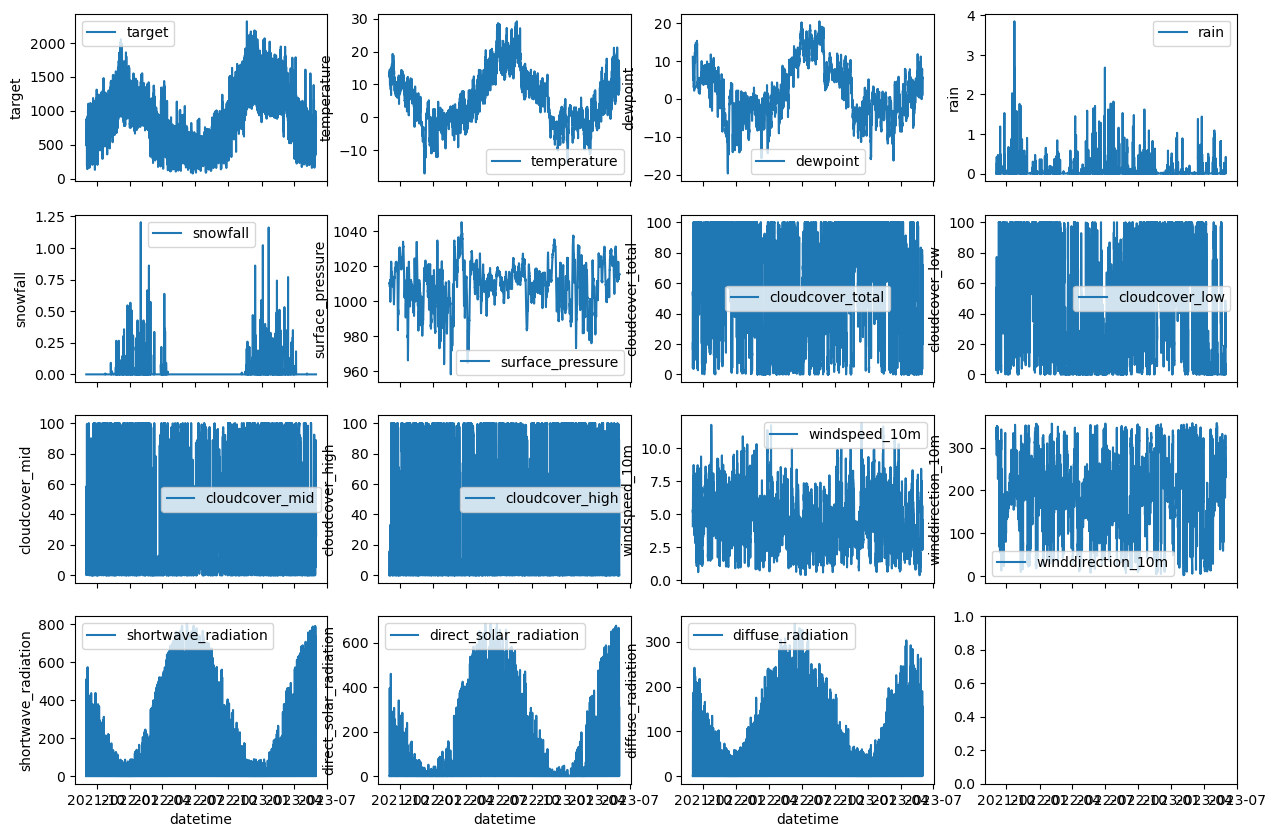

In [22]:
# 所有日期维度图
cols = ['target', 'temperature', 'dewpoint', 'rain', 'snowfall', 'surface_pressure', 'cloudcover_total', 
        'cloudcover_low', 'cloudcover_mid', 'cloudcover_high', 'windspeed_10m', 'winddirection_10m', 
        'shortwave_radiation', 'direct_solar_radiation', 'diffuse_radiation']
figure, axes = plt.subplots(4, 4, sharex=True, figsize=(15, 10))
for col, ax in zip(cols, axes.ravel()):
    sns.lineplot(data=merged_is_consumption_is_business, x='datetime', y=col, label=col, ax=ax)

### 消费且非商用和target相关性

In [23]:
merged_is_consumption_no_business = merged_is_consumption[(merged_is_consumption['county']==0)&(merged_is_consumption['product_type']==1)&(merged_is_consumption['is_business']==0)]
merged_is_consumption_no_business.corr().loc['target']

county                         NaN
data_block_id             0.550691
target                    1.000000
is_consumption                 NaN
is_business                    NaN
product_type                   NaN
hour                      0.048647
datetime                  0.550768
temperature              -0.554978
dewpoint                 -0.529545
rain                     -0.079653
snowfall                  0.194220
surface_pressure         -0.109797
cloudcover_total          0.281006
cloudcover_low            0.311225
cloudcover_mid            0.161576
cloudcover_high           0.057641
windspeed_10m             0.077589
winddirection_10m         0.056193
shortwave_radiation      -0.084875
direct_solar_radiation   -0.083867
diffuse_radiation        -0.068086
latitude                       NaN
longitude                      NaN
Name: target, dtype: float64

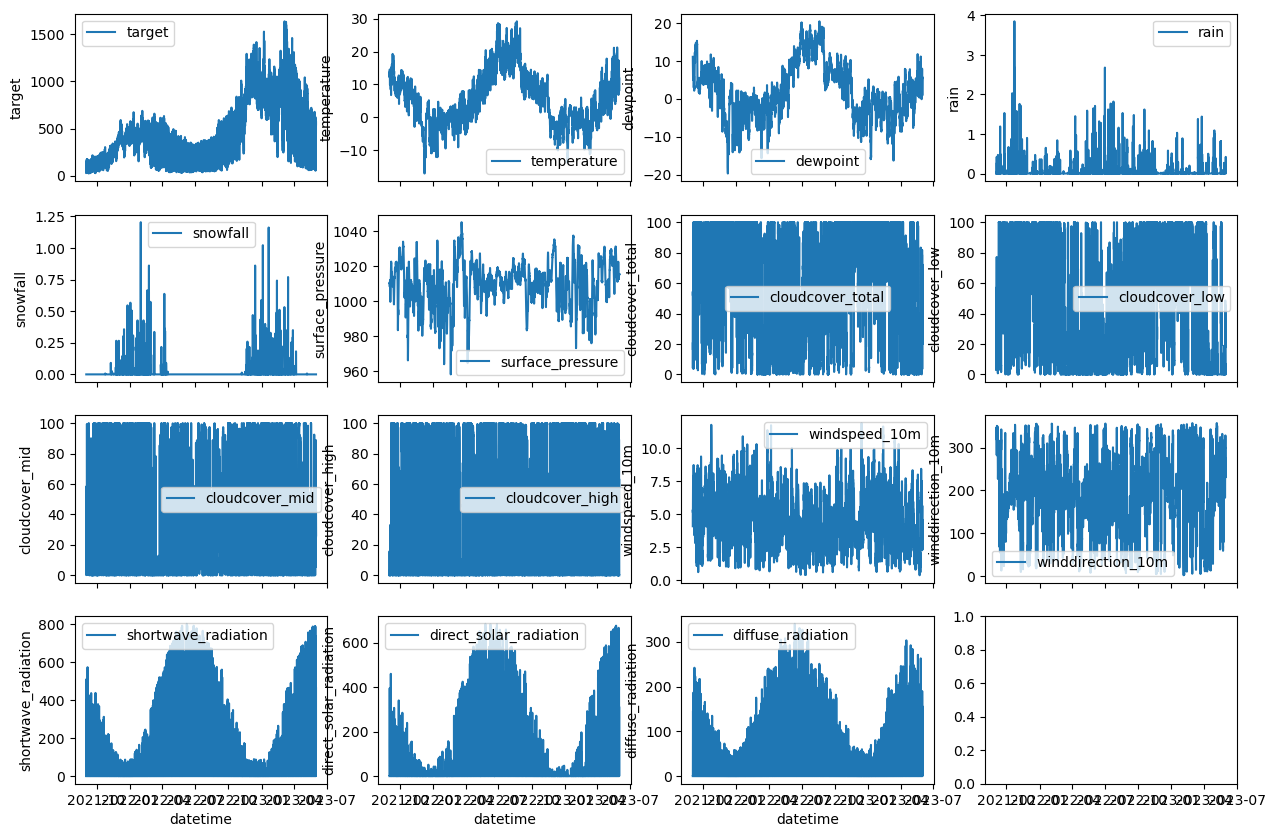

In [24]:
# 所有日期维度图
cols = ['target', 'temperature', 'dewpoint', 'rain', 'snowfall', 'surface_pressure', 'cloudcover_total', 
        'cloudcover_low', 'cloudcover_mid', 'cloudcover_high', 'windspeed_10m', 'winddirection_10m', 
        'shortwave_radiation', 'direct_solar_radiation', 'diffuse_radiation']
figure, axes = plt.subplots(4, 4, sharex=True, figsize=(15, 10))
for col, ax in zip(cols, axes.ravel()):
    sns.lineplot(data=merged_is_consumption_no_business, x='datetime', y=col, label=col, ax=ax)

## 生产target的相关性
### 生产且非商用和target的相关性

In [25]:
merged_no_consumption_no_business = merged_no_consumption[(merged_no_consumption['county']==0)&(merged_no_consumption['product_type']==1)&(merged_no_consumption['is_business']==0)]
merged_no_consumption_no_business.corr().loc['target']

county                         NaN
data_block_id             0.234545
target                    1.000000
is_consumption                 NaN
is_business                    NaN
product_type                   NaN
hour                      0.083737
datetime                  0.234676
temperature               0.187962
dewpoint                  0.166075
rain                     -0.037989
snowfall                 -0.076042
surface_pressure          0.134806
cloudcover_total         -0.273926
cloudcover_low           -0.299219
cloudcover_mid           -0.112580
cloudcover_high          -0.057645
windspeed_10m            -0.188894
winddirection_10m        -0.036096
shortwave_radiation      -0.191533
direct_solar_radiation   -0.161853
diffuse_radiation        -0.213728
latitude                       NaN
longitude                      NaN
Name: target, dtype: float64

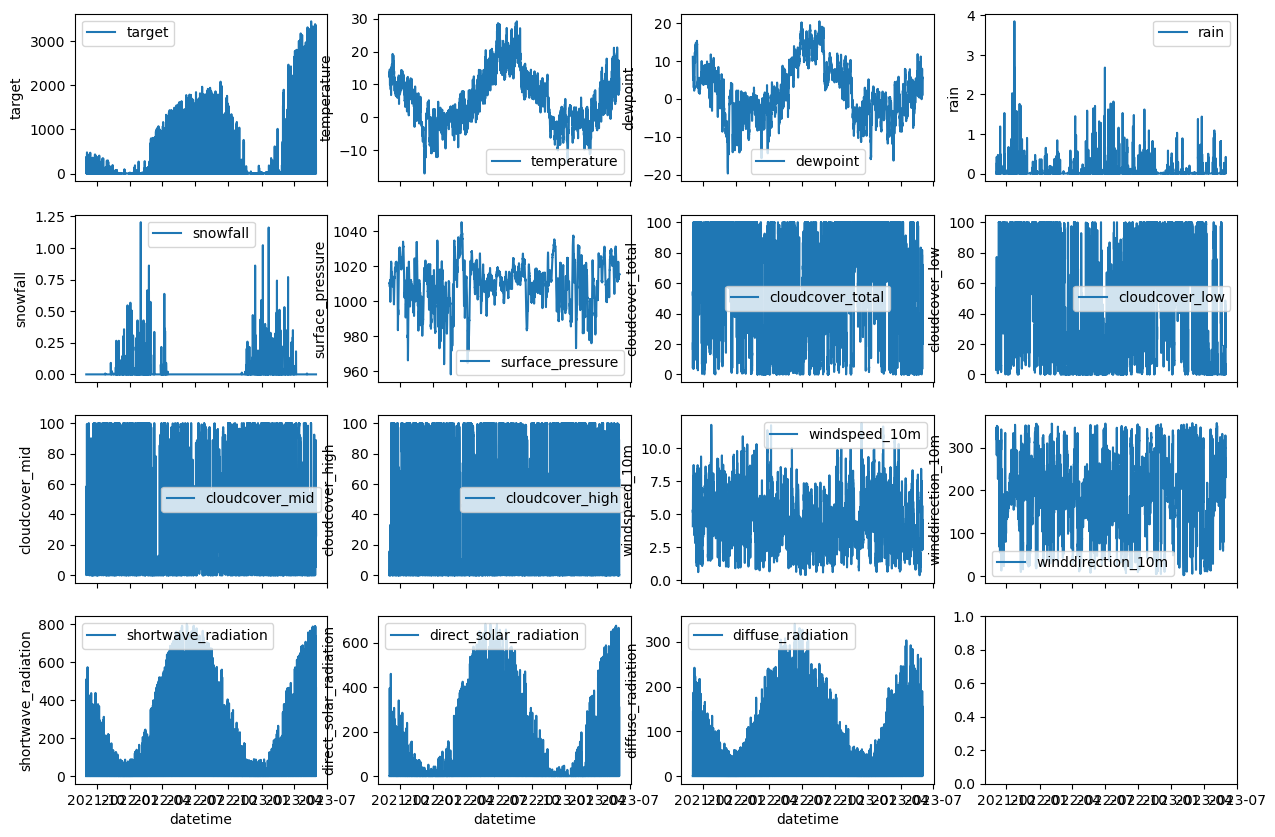

In [26]:
# 所有日期维度图
cols = ['target', 'temperature', 'dewpoint', 'rain', 'snowfall', 'surface_pressure', 'cloudcover_total', 
        'cloudcover_low', 'cloudcover_mid', 'cloudcover_high', 'windspeed_10m', 'winddirection_10m', 
        'shortwave_radiation', 'direct_solar_radiation', 'diffuse_radiation']
figure, axes = plt.subplots(4, 4, sharex=True, figsize=(15, 10))
for col, ax in zip(cols, axes.ravel()):
    sns.lineplot(data=merged_no_consumption_no_business, x='datetime', y=col, label=col, ax=ax)

### 生产且商用和target的相关性

In [27]:
merged_no_consumption_is_business = merged_no_consumption[(merged_no_consumption['county']==0)&(merged_no_consumption['product_type']==1)&(merged_no_consumption['is_business']==1)]
merged_no_consumption_is_business.corr().loc['target']

county                         NaN
data_block_id             0.180351
target                    1.000000
is_consumption                 NaN
is_business                    NaN
product_type                   NaN
hour                      0.074154
datetime                  0.180467
temperature               0.194088
dewpoint                  0.174415
rain                     -0.034474
snowfall                 -0.080381
surface_pressure          0.132119
cloudcover_total         -0.264108
cloudcover_low           -0.285206
cloudcover_mid           -0.110692
cloudcover_high          -0.060725
windspeed_10m            -0.180103
winddirection_10m        -0.030194
shortwave_radiation      -0.179464
direct_solar_radiation   -0.151755
diffuse_radiation        -0.200041
latitude                       NaN
longitude                      NaN
Name: target, dtype: float64

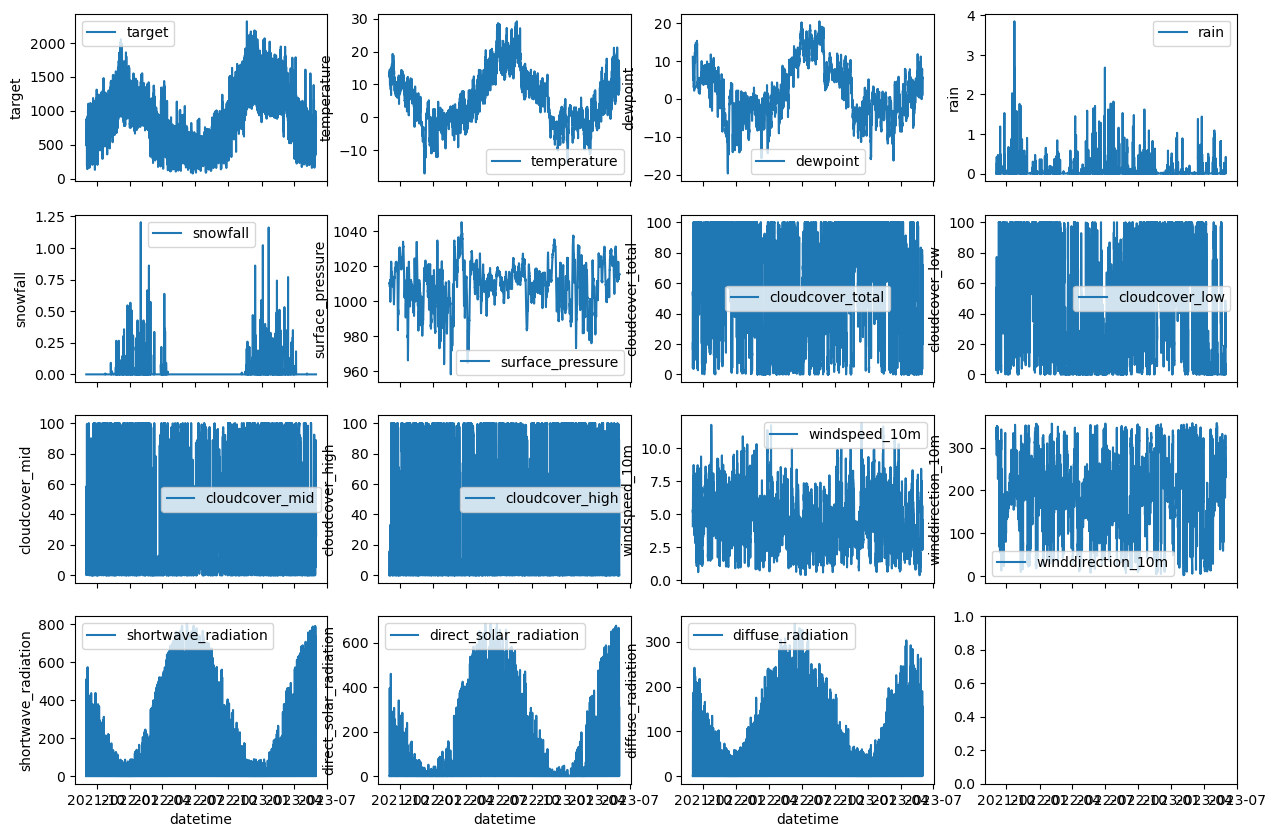

In [28]:
# 所有日期维度图
cols = ['target', 'temperature', 'dewpoint', 'rain', 'snowfall', 'surface_pressure', 'cloudcover_total', 
        'cloudcover_low', 'cloudcover_mid', 'cloudcover_high', 'windspeed_10m', 'winddirection_10m', 
        'shortwave_radiation', 'direct_solar_radiation', 'diffuse_radiation']
figure, axes = plt.subplots(4, 4, sharex=True, figsize=(15, 10))
for col, ax in zip(cols, axes.ravel()):
    sns.lineplot(data=merged_is_consumption_is_business, x='datetime', y=col, label=col, ax=ax)

<Axes: >

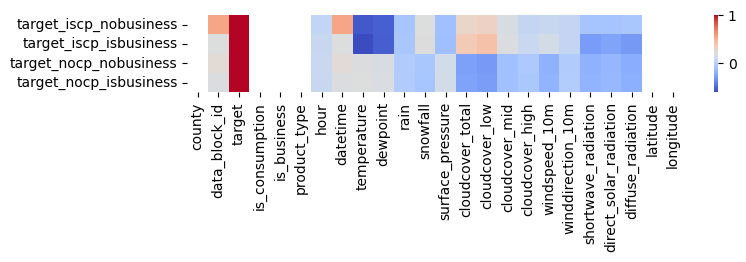

In [29]:
corr_no_consumption_is_business = merged_no_consumption_is_business.corr().loc['target']
corr_no_consumption_no_business = merged_no_consumption_no_business.corr().loc['target']
corr_is_consumption_is_business = merged_is_consumption_is_business.corr().loc['target']
corr_is_consumption_no_business = merged_is_consumption_no_business.corr().loc['target']
plt.figure(figsize=(8,1))
corr_is_consumption_no_business.rename('target_iscp_nobusiness', inplace=True)
corr_is_consumption_is_business.rename('target_iscp_isbusiness', inplace=True)
corr_no_consumption_no_business.rename('target_nocp_nobusiness', inplace=True)
corr_no_consumption_is_business.rename('target_nocp_isbusiness', inplace=True)
corr_data = pd.concat([corr_is_consumption_no_business, corr_is_consumption_is_business, corr_no_consumption_no_business,
                       corr_no_consumption_is_business], axis=1)
sns.heatmap(corr_data.T, cmap='coolwarm')

## 总结
综上，temperature,dewpoint,snowfall,cloudcover_total,cloudcover_low, shortwave_radiation,direct_solar_radiation,diffuse_radiation可作为筛选特征变量

# 预测天气部分

In [30]:
# 读取数据
forcast_weather = pd.read_csv('../data/forecast_weather.csv', parse_dates=['forecast_datetime'])
forcast_weather

,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,57.6,21.7,2021-09-01 00:00:00+00:00,1,15.655786,11.553613,0.904816,0.019714,0.000000,0.905899,-0.411328,-9.106137,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
1,57.6,22.2,2021-09-01 00:00:00+00:00,1,13.003931,10.689844,0.886322,0.004456,0.000000,0.886658,0.206347,-5.355405,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
2,57.6,22.7,2021-09-01 00:00:00+00:00,1,14.206567,11.671777,0.729034,0.005615,0.000000,0.730499,1.451587,-7.417905,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
3,57.6,23.2,2021-09-01 00:00:00+00:00,1,14.844507,12.264917,0.336304,0.074341,0.000626,0.385468,1.090869,-9.163999,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
4,57.6,23.7,2021-09-01 00:00:00+00:00,1,15.293848,12.458887,0.102875,0.088074,0.000015,0.176590,1.268481,-8.975766,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3424507,59.7,26.2,2023-05-30 00:00:00+00:00,48,10.150049,5.662744,0.061066,0.257339,0.004059,0.308594,6.890626,-3.258144,637,2023-06-01 00:00:00+00:00,0.0,0.0,0.0,0.0
3424508,59.7,26.7,2023-05-30 00:00:00+00:00,48,10.259790,5.922754,0.107880,0.895203,0.198700,0.906036,6.890626,-3.768032,637,2023-06-01 00:00:00+00:00,0.0,0.0,0.0,0.0
3424509,59.7,27.2,2023-05-30 00:00:00+00:00,48,10.467798,6.072534,0.000000,0.387466,0.448853,0.530518,6.214112,-4.700405,637,2023-06-01 00:00:00+00:00,0.0,0.0,0.0,0.0
3424510,59.7,27.7,2023-05-30 00:00:00+00:00,48,10.694116,7.009058,0.000000,0.505936,0.997314,0.997498,5.810060,-4.338345,637,2023-06-01 00:00:00+00:00,0.0,0.0,0.0,0.0


In [31]:
# 将经纬度乘以10并调整为整数型以减少内存占用
forcast_weather['latitude'] = forcast_weather['latitude']*10
forcast_weather['longitude'] = forcast_weather['longitude']*10
forcast_weather['latitude'] = forcast_weather['latitude'].astype(int)
forcast_weather['longitude'] = forcast_weather['longitude'].astype(int)
forcast_weather['hour'] = forcast_weather['forecast_datetime'].apply(lambda x: x.hour)
forcast_weather.head()

,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation,hour
0,576,217,2021-09-01 00:00:00+00:00,1,15.655786,11.553613,0.904816,0.019714,0.000000,0.905899,-0.411328,-9.106137,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0,1
1,576,222,2021-09-01 00:00:00+00:00,1,13.003931,10.689844,0.886322,0.004456,0.000000,0.886658,0.206347,-5.355405,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0,1
2,576,227,2021-09-01 00:00:00+00:00,1,14.206567,11.671777,0.729034,0.005615,0.000000,0.730499,1.451587,-7.417905,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0,1
3,576,232,2021-09-01 00:00:00+00:00,1,14.844507,12.264917,0.336304,0.074341,0.000626,0.385468,1.090869,-9.163999,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0,1
4,576,237,2021-09-01 00:00:00+00:00,1,15.293848,12.458887,0.102875,0.088074,0.000015,0.176590,1.268481,-8.975766,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0,1


In [32]:
# 拼接前的预测天气数据
len(forcast_weather)

3424512

In [33]:
# 筛选hours_ahead小于24的数据，即预测跨度为一天的数据
forcast_weather = forcast_weather[forcast_weather['hours_ahead'] >= 24]
len(forcast_weather)

1783600

In [34]:
# 对数据按照经纬度拼接
forcast_weather = pd.merge(left=forcast_weather, right=location, on=['latitude', 'longitude'])
# forcast_weather.drop_duplicates(subset=['county', 'origin_datetime'], inplace=True)
forcast_weather['county'].unique()
# 经过观察拼接后的county缺少了12

array([10, 15,  7, 13, 14, 11,  8,  4,  1,  6,  9,  3,  0,  5,  2],
      dtype=int64)

In [35]:
train_with_forecast_weather = pd.merge(left=train, right=forcast_weather, on=['county', 'data_block_id', 'hour'], how='left')
train_with_forecast_weather.drop_duplicates(subset=['row_id'], inplace=True)
train_with_forecast_weather

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,year,month,day,hour,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0,2021,9,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0,2021,9,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1,2021,9,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1,2021,9,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2,2021,9,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11263779,15,1,0,197.233,1,2023-05-31 23:00:00,637,2018347,64,2023,5,31,23,576.0,267.0,2023-05-30 00:00:00+00:00,47.0,9.185205,4.397241,0.570526,0.0,0.0,0.570526,3.161763,-0.698455,2023-05-31 23:00:00+00:00,0.0,0.0,0.0,0.0
11263784,15,1,1,0.000,0,2023-05-31 23:00:00,637,2018348,59,2023,5,31,23,576.0,267.0,2023-05-30 00:00:00+00:00,47.0,9.185205,4.397241,0.570526,0.0,0.0,0.570526,3.161763,-0.698455,2023-05-31 23:00:00+00:00,0.0,0.0,0.0,0.0
11263789,15,1,1,28.404,1,2023-05-31 23:00:00,637,2018349,59,2023,5,31,23,576.0,267.0,2023-05-30 00:00:00+00:00,47.0,9.185205,4.397241,0.570526,0.0,0.0,0.570526,3.161763,-0.698455,2023-05-31 23:00:00+00:00,0.0,0.0,0.0,0.0
11263794,15,1,3,0.000,0,2023-05-31 23:00:00,637,2018350,60,2023,5,31,23,576.0,267.0,2023-05-30 00:00:00+00:00,47.0,9.185205,4.397241,0.570526,0.0,0.0,0.570526,3.161763,-0.698455,2023-05-31 23:00:00+00:00,0.0,0.0,0.0,0.0


In [36]:
len(train)

2018352

In [37]:
len(train_with_forecast_weather)

2018352

In [38]:
# 查看拼接后数据的缺失值情况
train_with_forecast_weather.isnull().sum()

county                                   0
is_business                              0
product_type                             0
target                                 528
is_consumption                           0
datetime                                 0
data_block_id                            0
row_id                                   0
prediction_unit_id                       0
year                                     0
month                                    0
day                                      0
hour                                     0
latitude                             33504
longitude                            33504
origin_datetime                      33504
hours_ahead                          33504
temperature                          33504
dewpoint                             33504
cloudcover_high                      33504
cloudcover_low                       33504
cloudcover_mid                       33504
cloudcover_total                     33504
10_metre_u_

In [39]:
# 删除缺失值
train_with_forecast_weather.dropna(how='any', inplace=True)
train_with_forecast_weather.drop(columns=['forecast_datetime', 'origin_datetime'], inplace=True)

## 生产电量与预测天气的相关性
以county=2, product_type=1为例

### 商业生产电量与预测天气的相关性

In [40]:
train_forecast_no_consumption  = train_with_forecast_weather[(train_with_forecast_weather['is_consumption']==0) & 
                                                             (train_with_forecast_weather['county']==2) & 
                                                             (train_with_forecast_weather['product_type'] == 1) & 
                                                             (train_with_forecast_weather['is_business'] == 1)]
corr_no_consumption_is_business = train_forecast_no_consumption.corr()['target']
corr_no_consumption_is_business

county                                    NaN
is_business                               NaN
product_type                              NaN
target                               1.000000
is_consumption                            NaN
datetime                             0.024407
data_block_id                        0.024219
row_id                               0.023588
prediction_unit_id                        NaN
year                                -0.003156
month                                0.040172
day                                  0.022450
hour                                 0.097135
latitude                                  NaN
longitude                                 NaN
hours_ahead                          0.097135
temperature                          0.528462
dewpoint                             0.268787
cloudcover_high                     -0.097232
cloudcover_low                      -0.307835
cloudcover_mid                      -0.133898
cloudcover_total                  

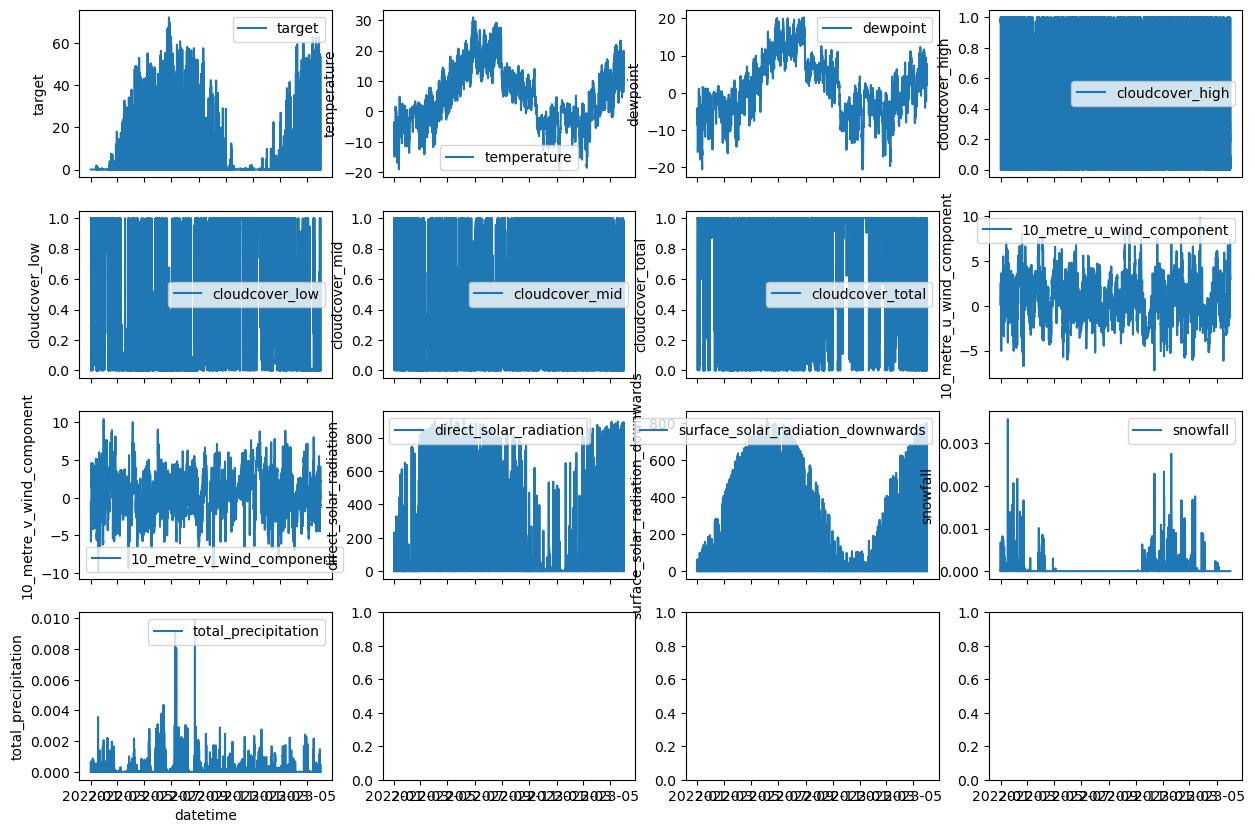

In [41]:
# 所有日期维度图
cols = ['target', 'temperature', 'dewpoint', 'cloudcover_high', 'cloudcover_low', 'cloudcover_mid', 
        'cloudcover_total', '10_metre_u_wind_component', '10_metre_v_wind_component', 'direct_solar_radiation', 'surface_solar_radiation_downwards', 
        'snowfall', 'total_precipitation']
figure, axes = plt.subplots(4, 4, sharex=True, figsize=(15, 10))
for col, ax in zip(cols, axes.ravel()):
    sns.lineplot(data=train_forecast_no_consumption, x='datetime', y=col, label=col, ax=ax)

### 非商业生产电量与预测天气的相关性

In [42]:
train_forecast_no_consumption  = train_with_forecast_weather[(train_with_forecast_weather['is_consumption']==0) & 
                                                             (train_with_forecast_weather['county']==2) & 
                                                             (train_with_forecast_weather['product_type'] == 1) & 
                                                             (train_with_forecast_weather['is_business'] == 0)]
corr_no_consumption_no_business = train_forecast_no_consumption.corr()['target']
corr_no_consumption_no_business

county                                    NaN
is_business                               NaN
product_type                              NaN
target                               1.000000
is_consumption                            NaN
datetime                             0.221966
data_block_id                        0.221865
row_id                               0.221025
prediction_unit_id                        NaN
year                                 0.214308
month                               -0.087302
day                                  0.019014
hour                                 0.061406
latitude                                  NaN
longitude                                 NaN
hours_ahead                          0.061406
temperature                          0.471169
dewpoint                             0.219349
cloudcover_high                     -0.092600
cloudcover_low                      -0.294572
cloudcover_mid                      -0.113685
cloudcover_total                  

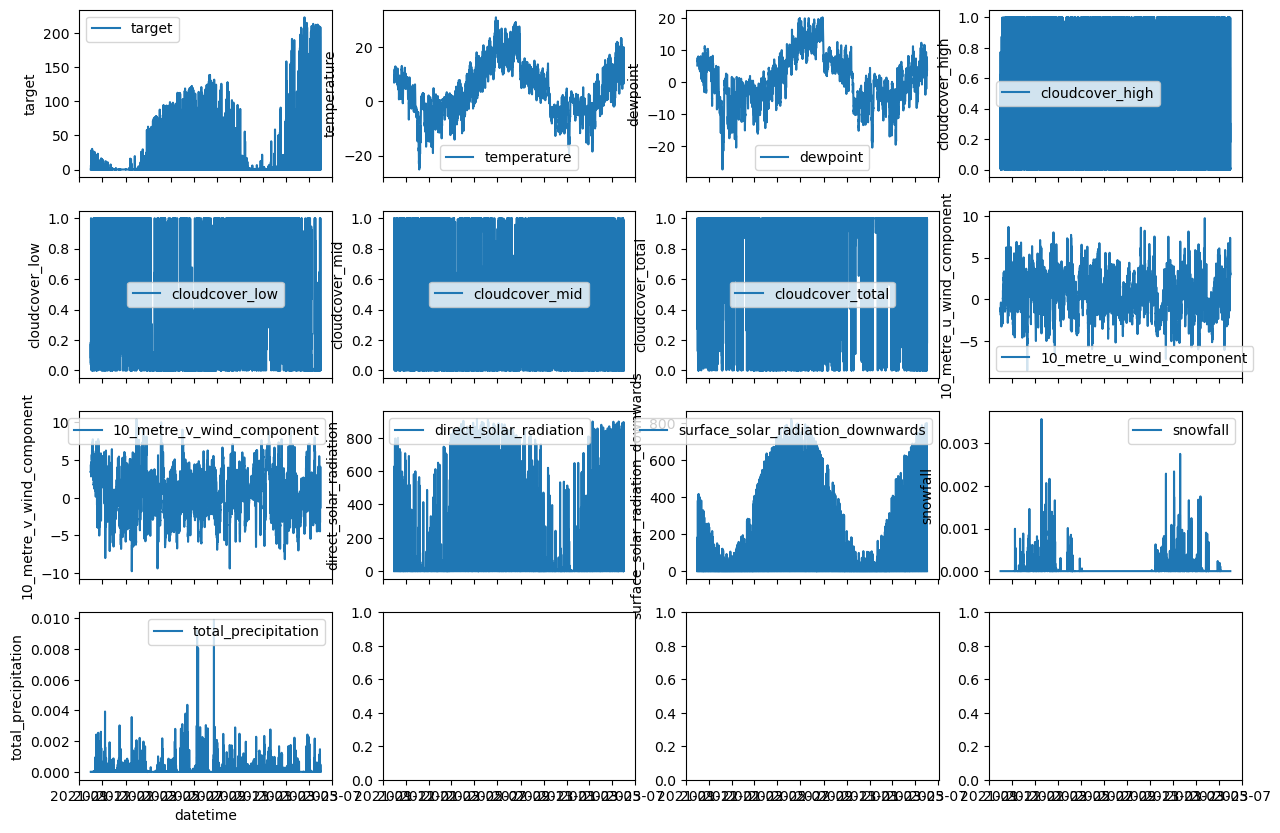

In [43]:
# 所有日期维度图
cols = ['target', 'temperature', 'dewpoint', 'cloudcover_high', 'cloudcover_low', 'cloudcover_mid', 
        'cloudcover_total', '10_metre_u_wind_component', '10_metre_v_wind_component', 'direct_solar_radiation', 'surface_solar_radiation_downwards', 
        'snowfall', 'total_precipitation']
figure, axes = plt.subplots(4, 4, sharex=True, figsize=(15, 10))
for col, ax in zip(cols, axes.ravel()):
    sns.lineplot(data=train_forecast_no_consumption, x='datetime', y=col, label=col, ax=ax)

## 消费电量与预测天气的相关性

### 商业消费电量与预测天气的相关性

In [44]:
train_forecast_is_consumption  = train_with_forecast_weather[(train_with_forecast_weather['is_consumption']==1) & 
                                                             (train_with_forecast_weather['county']==2) & 
                                                             (train_with_forecast_weather['product_type'] == 1) & 
                                                             (train_with_forecast_weather['is_business'] == 1)]
corr_is_consumption_is_business = train_forecast_is_consumption.corr()['target']
corr_is_consumption_is_business

county                                    NaN
is_business                               NaN
product_type                              NaN
target                               1.000000
is_consumption                            NaN
datetime                             0.187615
data_block_id                        0.187504
row_id                               0.188059
prediction_unit_id                        NaN
year                                 0.199295
month                               -0.044960
day                                 -0.060847
hour                                 0.057416
latitude                                  NaN
longitude                                 NaN
hours_ahead                          0.057416
temperature                         -0.397307
dewpoint                            -0.429379
cloudcover_high                      0.011089
cloudcover_low                       0.150954
cloudcover_mid                       0.104484
cloudcover_total                  

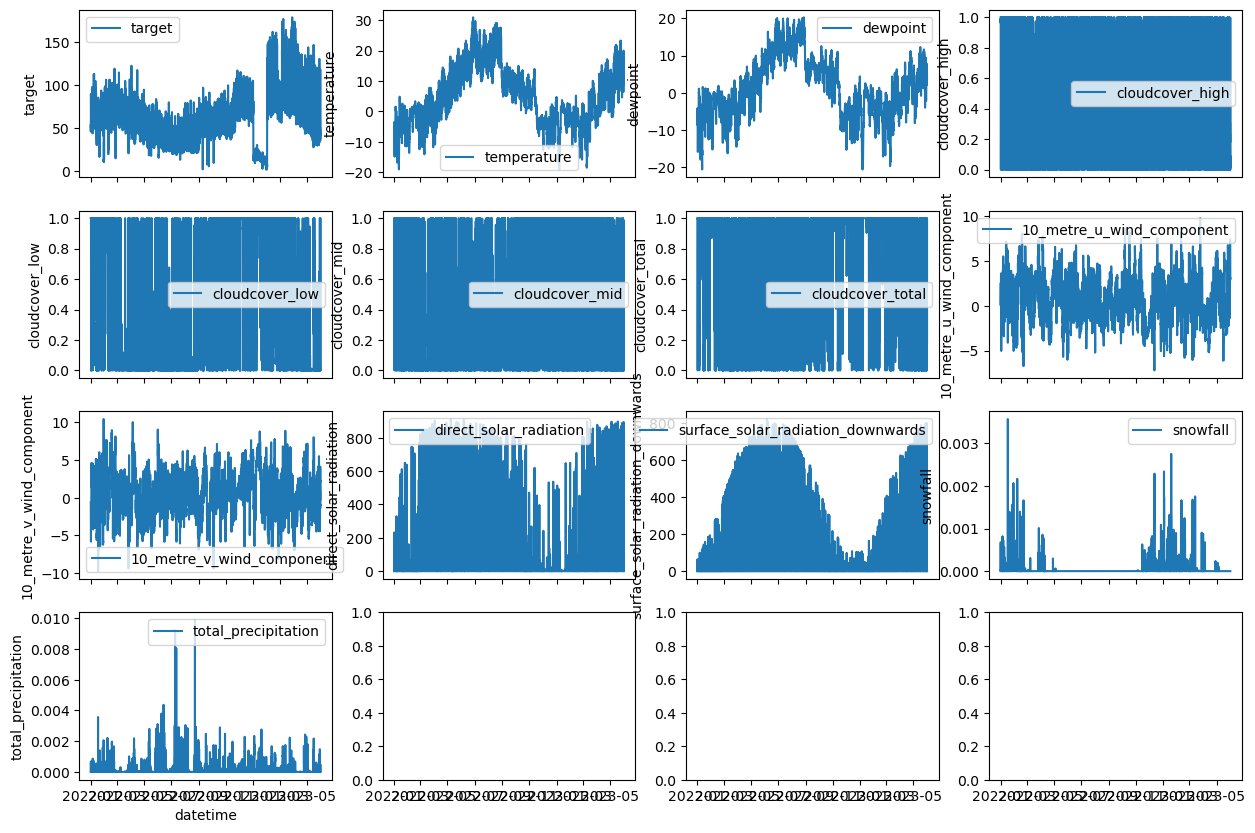

In [45]:
# 所有日期维度图
cols = ['target', 'temperature', 'dewpoint', 'cloudcover_high', 'cloudcover_low', 'cloudcover_mid', 
        'cloudcover_total', '10_metre_u_wind_component', '10_metre_v_wind_component', 'direct_solar_radiation', 'surface_solar_radiation_downwards', 
        'snowfall', 'total_precipitation']
figure, axes = plt.subplots(4, 4, sharex=True, figsize=(15, 10))
for col, ax in zip(cols, axes.ravel()):
    sns.lineplot(data=train_forecast_is_consumption, x='datetime', y=col, label=col, ax=ax)

### 非商业消费电量与预测天气的相关性

In [46]:
train_forecast_is_consumption  = train_with_forecast_weather[(train_with_forecast_weather['is_consumption']==1) & 
                                                             (train_with_forecast_weather['county']==2) & 
                                                             (train_with_forecast_weather['product_type'] == 1) & 
                                                             (train_with_forecast_weather['is_business'] == 0)]
corr_is_consumption_no_business = train_forecast_is_consumption.corr()['target']
corr_is_consumption_no_business

county                                    NaN
is_business                               NaN
product_type                              NaN
target                               1.000000
is_consumption                            NaN
datetime                             0.518004
data_block_id                        0.517886
row_id                               0.519506
prediction_unit_id                        NaN
year                                 0.472839
month                               -0.146909
day                                 -0.054073
hour                                 0.071991
latitude                                  NaN
longitude                                 NaN
hours_ahead                          0.071991
temperature                         -0.594492
dewpoint                            -0.517949
cloudcover_high                      0.077881
cloudcover_low                       0.315915
cloudcover_mid                       0.154951
cloudcover_total                  

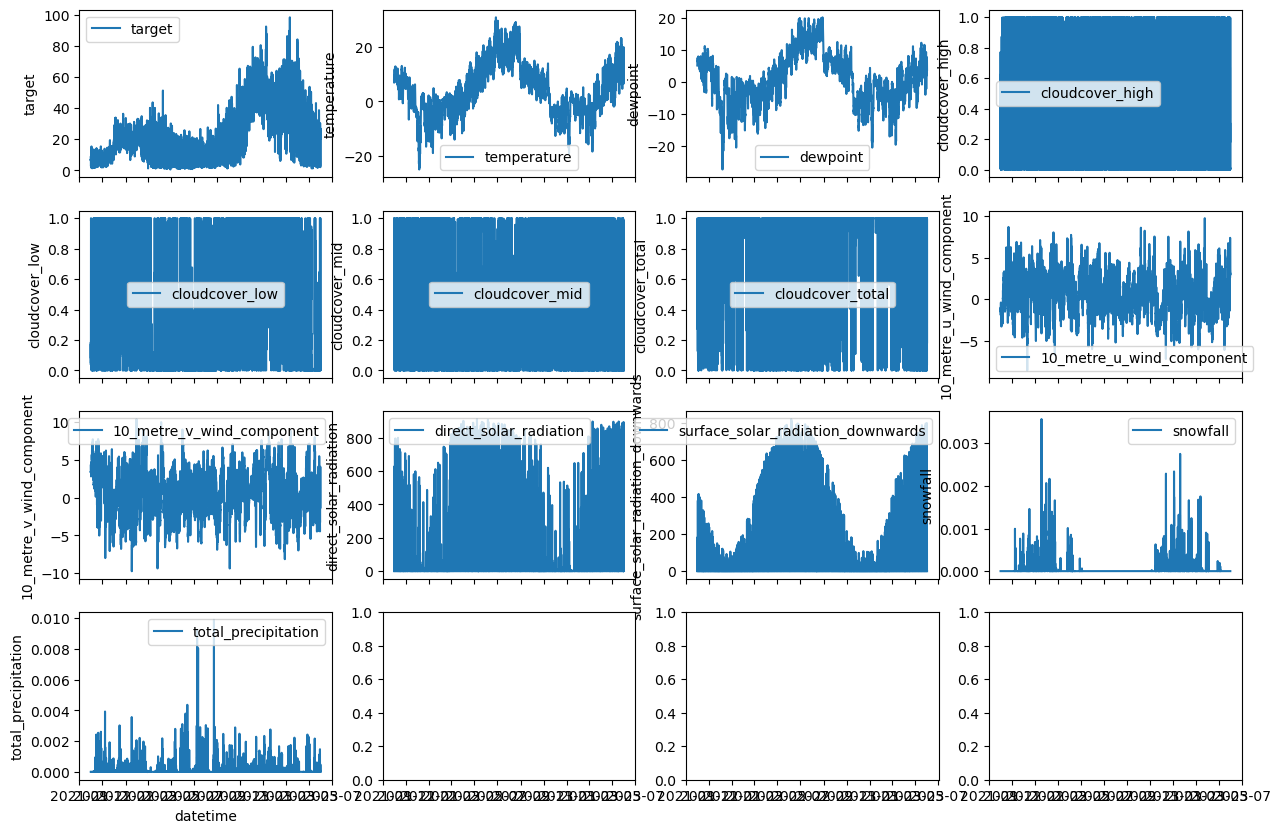

In [47]:
# 所有日期维度图
cols = ['target', 'temperature', 'dewpoint', 'cloudcover_high', 'cloudcover_low', 'cloudcover_mid', 
        'cloudcover_total', '10_metre_u_wind_component', '10_metre_v_wind_component', 'direct_solar_radiation', 'surface_solar_radiation_downwards', 
        'snowfall', 'total_precipitation']
figure, axes = plt.subplots(4, 4, sharex=True, figsize=(15, 10))
for col, ax in zip(cols, axes.ravel()):
    sns.lineplot(data=train_forecast_is_consumption, x='datetime', y=col, label=col, ax=ax)

<Axes: >

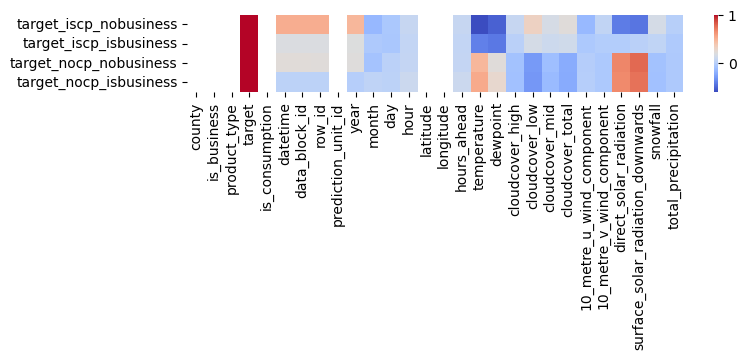

In [48]:
plt.figure(figsize=(8,1))
corr_is_consumption_no_business.rename('target_iscp_nobusiness', inplace=True)
corr_is_consumption_is_business.rename('target_iscp_isbusiness', inplace=True)
corr_no_consumption_no_business.rename('target_nocp_nobusiness', inplace=True)
corr_no_consumption_is_business.rename('target_nocp_isbusiness', inplace=True)
corr_data = pd.concat([corr_is_consumption_no_business, corr_is_consumption_is_business, corr_no_consumption_no_business, 
                       corr_no_consumption_is_business], axis=1)
sns.heatmap(corr_data.T, cmap='coolwarm')

## 总结
综上, temperature, dewpoint, cloudcover_low, cloudcover_total, direct_solar_radiation, surface_solar_radiation_downwards, snowfall可作为筛选后特征变量